# MLP for face keypoint detection

In [1]:
from faceKeySrc import load_data,linear_regresion, shared_dataset, plot_train_valid,train_early_stopping
import theano.tensor as T
import theano
import numpy

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled)


In [2]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
X, Y = load_data(FTRAIN)

just drop all the samples with missing values, consider a better approach


In [3]:
# generate train and validation sets
from sklearn.cross_validation import train_test_split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

## implement the MLP using lisa-lab's guide

In [4]:
# implement the hidden layer class
class HiddenLayer(object):
    def __init__(self,
                 rng,
                 input,
                 n_in,
                 n_out,
                 W=None,
                 b=None,
                 activation=T.tanh):
        """units are fully connected
        sigmoidial activation functin 
        shape of W : (n_in,n_out)
        shape of b : (n_out,)
        
        :type rng: numpy.random.RandomState
        :param rng: random number generator for initializing W
        
        :type input: theano.tensor.dmatrix
        :param input:symbolic tensor of the shape (n_examples, n_input)
        
        :type n_in: int
        :param n_in: dimensionality of input
        
        :type n_out: int
        :param n_out: number of hidden units
        
        :type activation: theano.Op or function
        param activation: Non-linearity of the hidden units
        
        """
        
        #keep track of input
        self.input = input
        
        #initializing network weight
        
        #W uniformely sampled from -sqrt(6./(n_in+n_hidden)) and 
        # sqrt(6./(n_in+n_hidden)) for tanh function
        if W is None:
            W_values = numpy.array(
                rng.uniform(
                    low = -numpy.sqrt(6. / (n_in + n_out)),
                    high = numpy.sqrt(6. / (n_in + n_out)),
                    size = (n_in , n_out)
                ),
                dtype = theano.config.floatX
            )
            
            if activation == theano.tensor.nnet.sigmoid: # for sigmoid function
                W_values *= 4
                
            W = theano.shared( value=W_values, name='W' , borrow = True)
            
        if b is None:
            b_values = numpy.zeros((n_out, ), dtype = theano.config.floatX)
            b = theano.shared(value = b_values, name = 'b' , borrow = True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )        
        # parameters of the model 
        self.param = [self.W, self.b]
        

In [5]:
class MLP(object):
    """Multi-layer perceptron class
    
    Feed-forward neural network with one or more hidden layers
    and non-linear activation defined by hiddenLayer and 
    the output layer defined by linear_regresion
    """
    
    def __init__(self,
                 rng,
                 input,
                 n_in,
                 n_hidden,
                 n_out):
        """initializing a MLP
        
        :type rng: numpy.random.RandomState
        :param rng: random number generator for initializing MLP weights
        
        :type input: theano.tensor.TensorType
        :param input: symbolic representation of the input samples
        
        :type n_in: int 
        :pram n_in:  number of input units, dimension of input space
        
        :type n_hidden: int
        :param n_hidden:number of hidden units
        
        :type n_out: int
        :param n_out:number of output units
        
        """
        
        # for now we make the assumption that we have a single layer MLP
        # activation functions tanh or sigmoid 
        # output layer is multi-target regression defined in linear_regresion
        
        self.hiddenLayer = HiddenLayer(rng = rng,
                                       input = input,
                                       n_in = n_in,
                                       n_out = n_hidden,
                                       activation=T.tanh)
        
        # linear regression layer takes the output of the hidden layer
        self.regression = linear_regresion( input = self.hiddenLayer.output,
                                           n_in = n_hidden,
                                           n_out = n_out)
        
        # define the L1 norm for regularization 
        self.L1= (
        abs(self.hiddenLayer.W).sum()
            + abs(self.regression.W).sum()
            )
        # define the L2 regularization term 
        self.L2= (
        abs(self.hiddenLayer.W**2).sum()
            + abs(self.regression.W**2).sum()
            )
        #the loss of the MLP is given by the MSE  loss of the regression layer
        self.MSE= (
            self.regression.loss_MSE    
            )
        # computing the number of error? 
        # this is for accuracy calculation not necessary for regression
        
        # parameters of the model
        self.param  = self.hiddenLayer.param + self.regression.param
        
        # kepp track of the input
        self.input = input 
        

In [6]:
def sgd_MLP_singleHidden_earlystop (train_set_x, train_set_y,
                                    valid_set_x, valid_set_y,
                                    learning_rate=0.01,
                                    L1_reg=0.00,
                                    L2_reg=0.0001,
                                    n_epochs=1000,
                                    batch_size=10,
                                    n_hidden=100,
                                    patience = 500,
                                    improvement_threshold = 0.995,
                                    patience_increase = 2):
    """stochastic gradient descend optimization of single layer MLP with early stopping    
    """
    #compute the number of mini batches
    n_train_batches= train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    
    print('...building the model')
    
    # allocate symbolic variable for data
    index = T.lscalar()
    
    # generate symbolic variable for data - x, y represent a single batch
    x= T.matrix('x')
    y=T.matrix('y')
    
    # random number generator 
    rng = numpy.random.RandomState(1364)
    
    # construct the MLP class
    regressor=MLP(rng,
                   input=x,
                   n_in=96 * 96,
                   n_hidden=n_hidden,
                   n_out=30
                  )
    
    # the cost function 
    cost = (regressor.MSE(y)
            + L1_reg * regressor.L1
            + L2_reg * regressor.L2
           )
    
    # compile a theano function to report the validation cost
    validate_model = theano.function(
        inputs=[index],
        outputs = regressor.MSE(y)+ L1_reg * regressor.L1+ L2_reg * regressor.L2,
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    # compute the gradient wrt to parameters
    gparams = [T.grad(cost,param) for param in regressor.param]
    
    # specify the update procedure for the regressor 
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(regressor.param, gparams)
    ]
    
    # compile the train model which returns the cost and updates 
    # the model accordingly
    
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    history_train_loss, history_validation_loss=train_early_stopping(train_model=train_model,
                                                                     validate_model=validate_model,
                                                                     n_epochs=n_epochs,
                                                                     n_train_batches=n_train_batches,
                                                                     n_valid_batches=n_valid_batches,
                                                                     patience = patience,
                                                                     improvement_threshold = improvement_threshold, 
                                                                     patience_increase = patience_increase
                                                                    )
    return history_train_loss, history_validation_loss

In [10]:
history_train_loss, history_validation_loss= sgd_MLP_singleHidden_earlystop(train_set_x, train_set_y,
                                                                            valid_set_x, valid_set_y,
                                                                            learning_rate=0.01,
                                                                            n_epochs=300,
                                                                            batch_size=100,
                                                                            patience = 500, 
                                                                            improvement_threshold = 0.999,
                                                                            patience_increase = 2, 
                                                                           )

...building the model


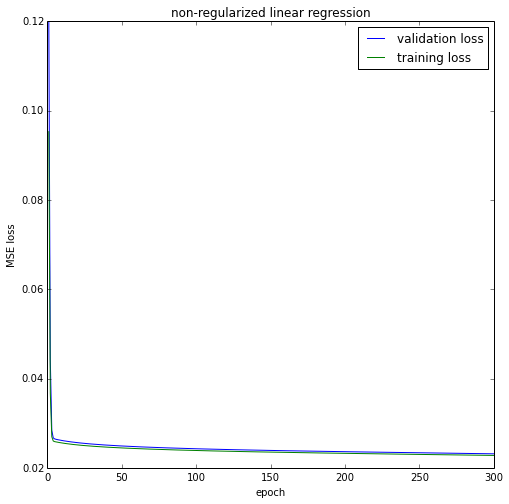

In [11]:
%matplotlib inline
plot_train_valid(history_train_loss=history_train_loss,
                 history_validation_loss=history_validation_loss)